In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import math
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
import warnings

warnings.filterwarnings("ignore")

In [2]:
mer_df = pd.read_csv('mergedstocktweet.csv')

In [3]:
mer_df.head()

,ticker,date,adj_close,close,high,low,open,volume,prev_close_1,prev_close_2,prev_close_3,close_t_plus_1,close_t_plus_3,close_t_plus_7,daily_return,ma_5,sentiment
0,AMZN,08/01/2020,94.598503,94.598503,95.550003,94.321999,94.902000,70160000,95.343002,95.143997,93.748497,95.052498,94.565002,93.236000,-0.007809,94.746899,NaN
1,MSFT,19/05/2020,177.436157,183.630005,186.600006,183.490005,185.029999,26799100,184.910004,183.160004,180.529999,185.660004,183.509995,183.250000,-0.006922,182.396002,NaN
2,NVDA,09/04/2020,65.520805,65.737503,68.230003,65.105003,68.000000,52556400,66.737503,64.757500,67.099998,67.462502,70.209999,67.377502,-0.014984,65.062001,NaN
3,NVDA,20/11/2020,130.544632,130.877502,134.945007,130.649994,134.539993,34108800,134.402496,134.287506,134.222504,131.399994,132.347504,135.445007,-0.026227,133.788501,0.479733
4,AMZN,01/05/2020,114.302002,114.302002,118.122002,112.909500,116.839996,195452000,123.699997,118.635498,115.704002,115.799499,117.563003,117.847504,-0.075974,118.228301,0.074767


In [4]:
mer_df.shape

(1235, 17)

In [5]:
mer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ticker          1235 non-null   object 
 1   date            1235 non-null   object 
 2   adj_close       1235 non-null   float64
 3   close           1235 non-null   float64
 4   high            1235 non-null   float64
 5   low             1235 non-null   float64
 6   open            1235 non-null   float64
 7   volume          1235 non-null   int64  
 8   prev_close_1    1230 non-null   float64
 9   prev_close_2    1225 non-null   float64
 10  prev_close_3    1220 non-null   float64
 11  close_t_plus_1  1235 non-null   float64
 12  close_t_plus_3  1235 non-null   float64
 13  close_t_plus_7  1235 non-null   float64
 14  daily_return    1230 non-null   float64
 15  ma_5            1235 non-null   float64
 16  sentiment       820 non-null    float64
dtypes: float64(14), int64(1), object(

In [6]:
mer_df.describe()

,adj_close,close,high,low,open,volume,prev_close_1,prev_close_2,prev_close_3,close_t_plus_1,close_t_plus_3,close_t_plus_7,daily_return,ma_5,sentiment
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03,1230.000000,1225.000000,1220.000000,1235.000000,1235.000000,1235.000000,1230.000000,1235.000000,820.000000
mean,120.352138,121.991374,123.929488,119.788716,121.886011,1.148069e+08,121.787216,121.574331,121.366054,122.357493,123.074900,124.557532,0.004209,121.263313,0.112107
std,48.751807,50.192909,50.656602,49.604321,50.210130,9.704000e+07,50.126686,50.040669,49.972292,50.216471,50.266860,50.443034,0.037125,50.014592,0.247491
min,24.081333,24.081333,26.990667,23.367332,24.980000,1.451220e+07,24.081333,24.081333,24.081333,24.081333,24.081333,24.081333,-0.210628,27.745067,-0.680800
25%,78.045811,79.778751,80.727501,78.983749,79.649998,4.242200e+07,79.729378,79.712502,79.656252,79.954998,80.519917,82.337502,-0.012154,79.251752,0.000000
50%,118.410858,119.209999,120.970001,117.155502,118.738998,8.693980e+07,119.040001,118.980499,118.720001,119.489998,120.511002,121.892502,0.003521,118.632402,0.094572
75%,157.215500,158.244995,160.097244,156.288750,158.651505,1.507010e+08,158.169746,158.128998,158.066246,158.387497,158.787750,159.431999,0.020653,157.822449,0.235805
max,231.666672,231.666672,232.860001,227.350006,229.270004,9.140820e+08,231.666672,231.649994,231.649994,231.666672,231.666672,235.223328,0.198949,227.988000,0.913600


In [7]:
mer_df.isnull().sum()

ticker              0
date                0
adj_close           0
close               0
high                0
low                 0
open                0
volume              0
prev_close_1        5
prev_close_2       10
prev_close_3       15
close_t_plus_1      0
close_t_plus_3      0
close_t_plus_7      0
daily_return        5
ma_5                0
sentiment         415
dtype: int64

In [8]:
mer_df['ticker'].value_counts()

ticker
AMZN    247
MSFT    247
NVDA    247
TSLA    247
AAPL    247
Name: count, dtype: int64

In [9]:
tweet_df = pd.read_csv('stocktweet.csv')
AAPL_df = pd.read_csv('AAPL.csv')
AMZN_df = pd.read_csv('AMZN.csv')
MSFT_df = pd.read_csv('MSFT.csv')
NVDA_df = pd.read_csv('NVDA.csv')
TSLA_df = pd.read_csv('TSLA.csv')

In [10]:
stock_dfs = {'AAPL': AAPL_df, 'AMZN': AMZN_df, 'MSFT': MSFT_df, 'NVDA': NVDA_df, 'TSLA': TSLA_df}

for ticker, df in stock_dfs.items():
    print(f"\n[{ticker}]")
    print(df.info())
    print(df.describe())
    print(df.head(3))


[AAPL]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       254 non-null    object 
 1   Open       254 non-null    float64
 2   High       254 non-null    float64
 3   Low        254 non-null    float64
 4   Close      254 non-null    float64
 5   Adj Close  254 non-null    float64
 6   Volume     254 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.0+ KB
None
             Open        High         Low       Close   Adj Close  \
count  254.000000  254.000000  254.000000  254.000000  254.000000   
mean    95.177963   96.570266   93.828021   95.260718   93.308248   
std     22.014834   22.099098   21.579560   21.810137   21.574201   
min     57.020000   57.125000   53.152500   56.092499   54.776802   
25%     76.863749   77.998749   76.109377   77.379377   75.390965   
50%     91.264999   92.793751   90.738750   91

In [11]:
tweet_df.head()


,id,date,ticker,tweet
0,100001,01/01/2020,AMZN,$AMZN Dow futures up by 100 points already 🥳
1,100002,01/01/2020,TSLA,$TSLA Daddy's drinkin' eArly tonight! Here's t...
2,100003,01/01/2020,AAPL,$AAPL We’ll been riding since last December fr...
3,100004,01/01/2020,TSLA,"$TSLA happy new year, 2020, everyone🍷🎉🙏"
4,100005,01/01/2020,TSLA,"$TSLA haha just a collection of greats...""Mars..."


for ticker, df in stock_dfs.items():
    print(f"\nMissing values in {ticker}:")
    print(df.isnull().sum())

print("\nMissing values in tweet_df:")
print(tweet_df.isnull().sum())


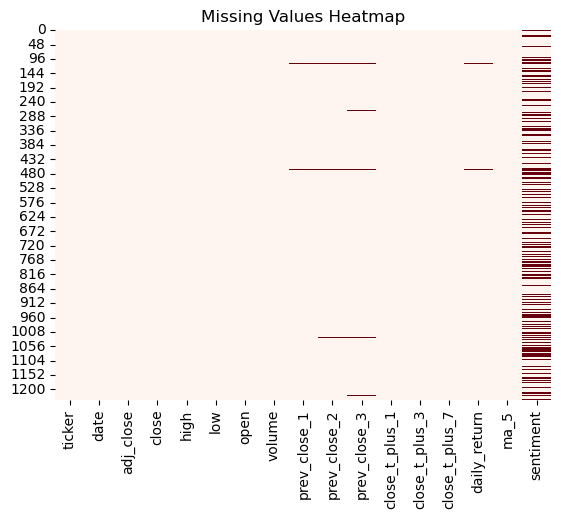

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(mer_df.isnull(), cbar=False, cmap='Reds')
plt.title("Missing Values Heatmap")
plt.show()


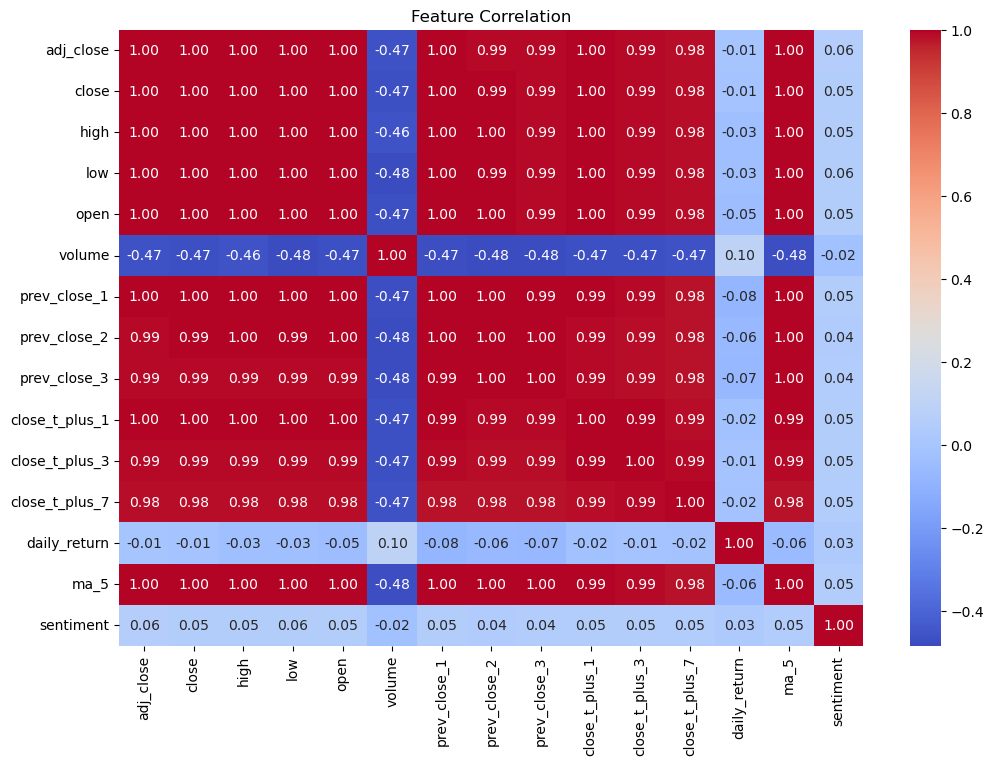

In [14]:
corr = mer_df.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation")
plt.show()

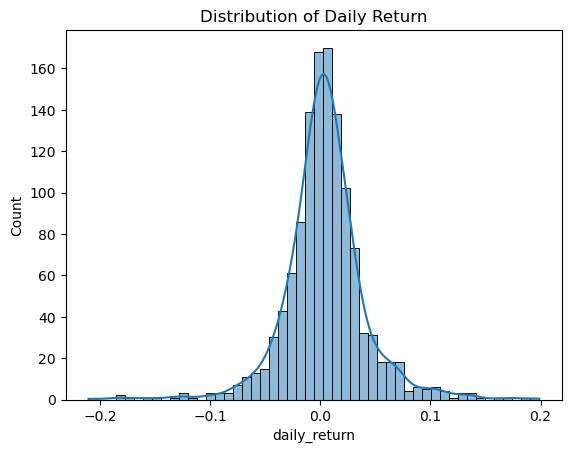

In [15]:
sns.histplot(mer_df['daily_return'].dropna(), bins=50, kde=True)
plt.title("Distribution of Daily Return")
plt.show()

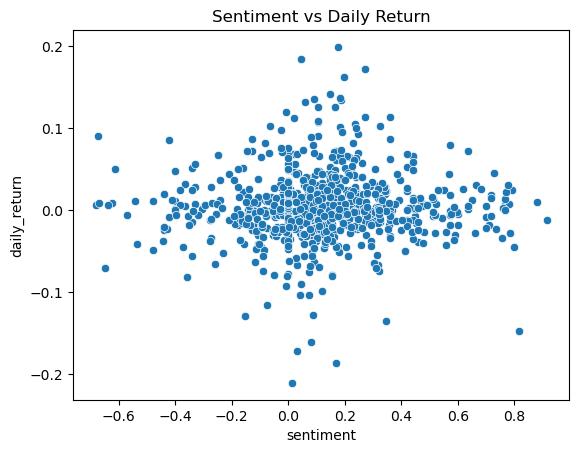

In [16]:
sns.scatterplot(data=mer_df, x='sentiment', y='daily_return')
plt.title("Sentiment vs Daily Return")
plt.show()

In [17]:
mer_df['date'] = pd.to_datetime(mer_df['date'], dayfirst=True)

In [18]:
mer_df = mer_df.sort_values(by=['ticker', 'date'])

In [19]:
mer_df = mer_df.dropna(subset=['close'])

In [20]:
print(f"Missing sentiment values: {mer_df['sentiment'].isna().sum()} out of {len(mer_df)}")

Missing sentiment values: 415 out of 1235


In [21]:
mer_df['sentiment'] = mer_df['sentiment'].fillna(0)

In [22]:
print(f"Missing sentiment after imputation: {mer_df['sentiment'].isna().sum()}")

Missing sentiment after imputation: 0


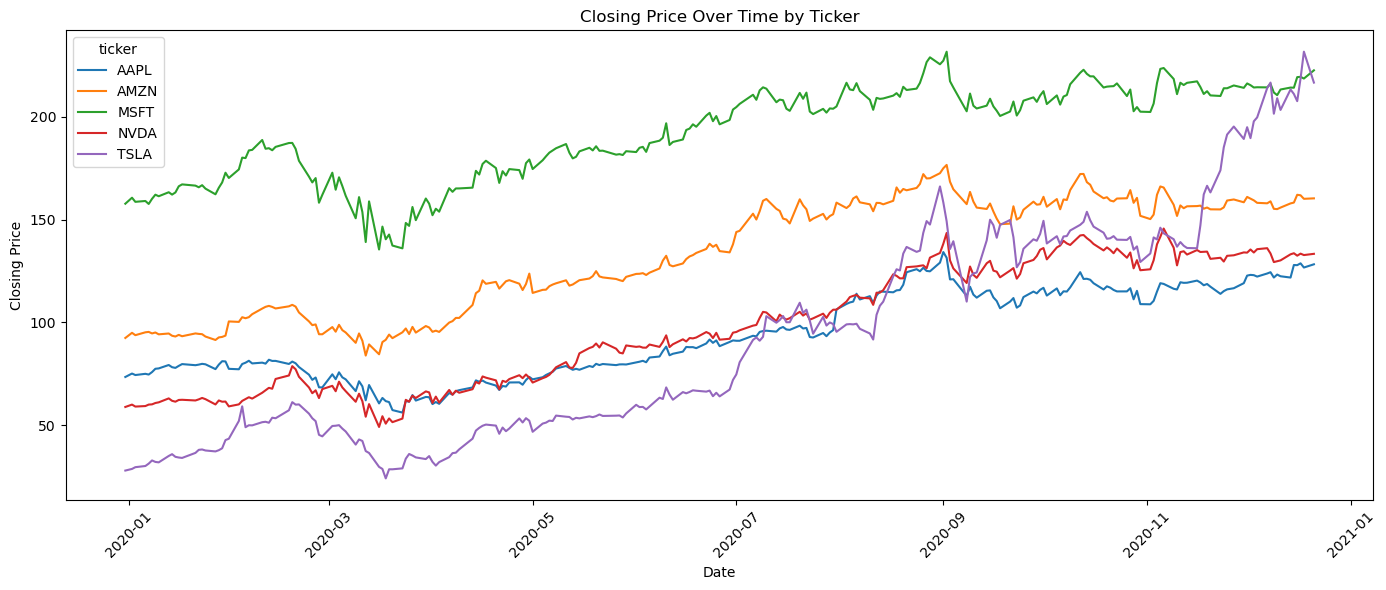

In [23]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=mer_df, x='date', y='close', hue='ticker')
plt.title('Closing Price Over Time by Ticker')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

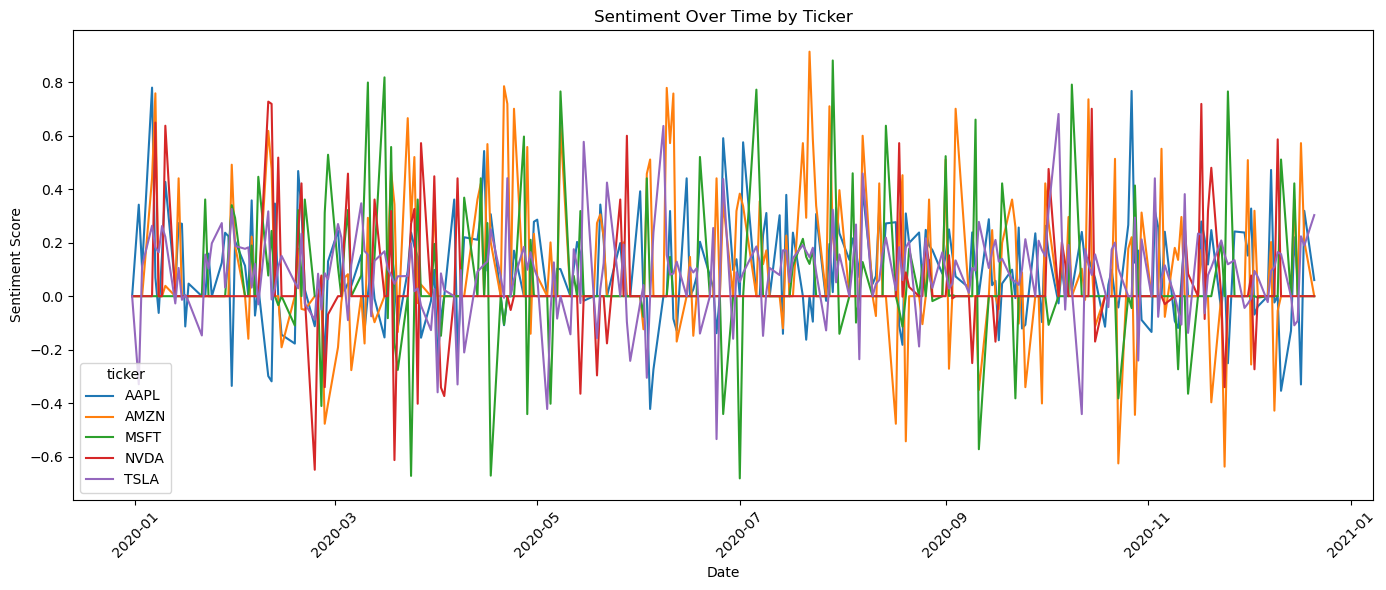

In [24]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=mer_df, x='date', y='sentiment', hue='ticker')
plt.title('Sentiment Over Time by Ticker')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

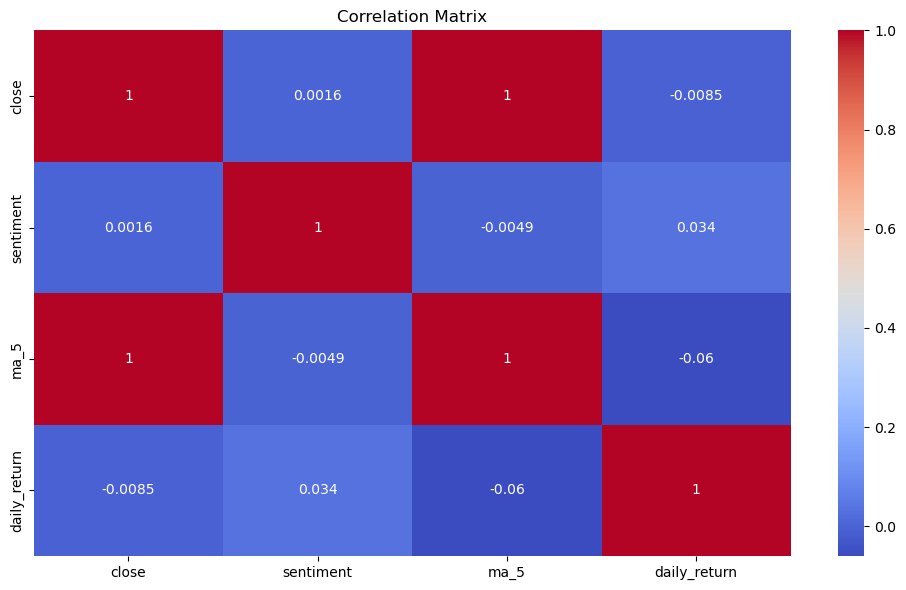

In [25]:
plt.figure(figsize=(10, 6))
corr_matrix = mer_df[['close', 'sentiment', 'ma_5', 'daily_return']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


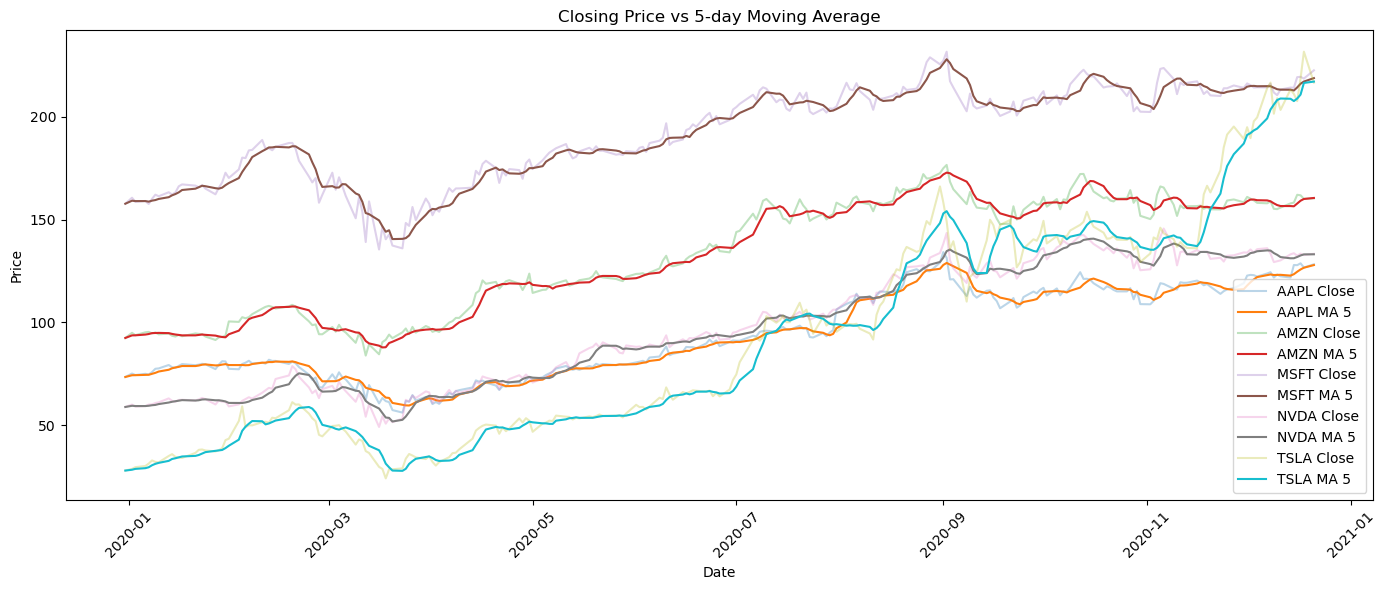

In [26]:
plt.figure(figsize=(14, 6))
for ticker in mer_df['ticker'].unique():
    ticker_df = mer_df[mer_df['ticker'] == ticker]
    plt.plot(ticker_df['date'], ticker_df['close'], label=f'{ticker} Close', alpha=0.3)
    plt.plot(ticker_df['date'], ticker_df['ma_5'], label=f'{ticker} MA 5')
plt.legend()
plt.title('Closing Price vs 5-day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

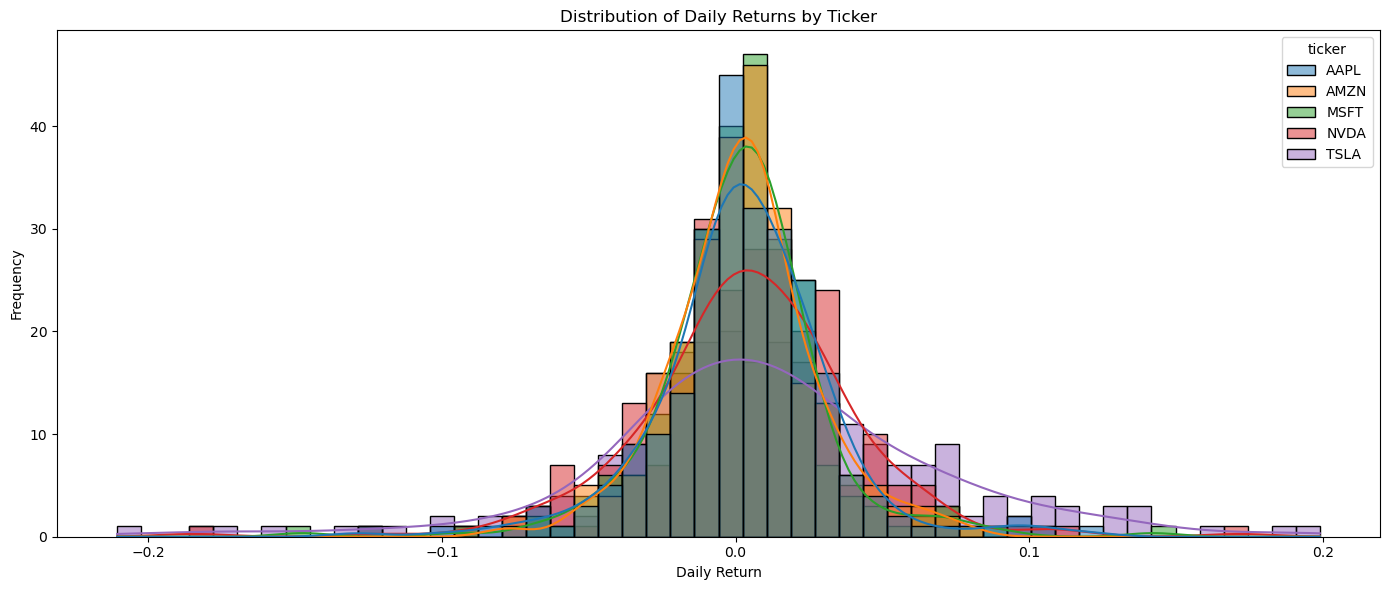

In [27]:
plt.figure(figsize=(14, 6))
sns.histplot(data=mer_df, x='daily_return', hue='ticker', kde=True, bins=50)
plt.title('Distribution of Daily Returns by Ticker')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

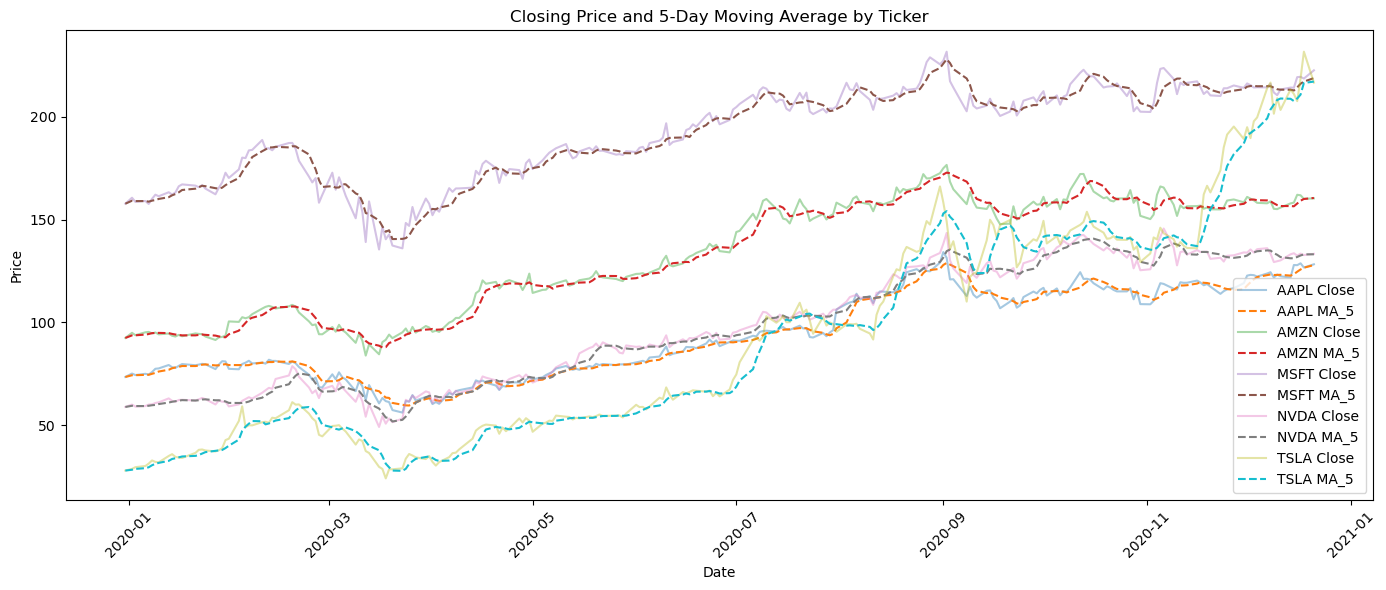

In [28]:
plt.figure(figsize=(14, 6))
for ticker in mer_df['ticker'].unique():
    df = mer_df[mer_df['ticker'] == ticker]
    plt.plot(df['date'], df['close'], label=f'{ticker} Close', alpha=0.4)
    plt.plot(df['date'], df['ma_5'], label=f'{ticker} MA_5', linestyle='--')
plt.title('Closing Price and 5-Day Moving Average by Ticker')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

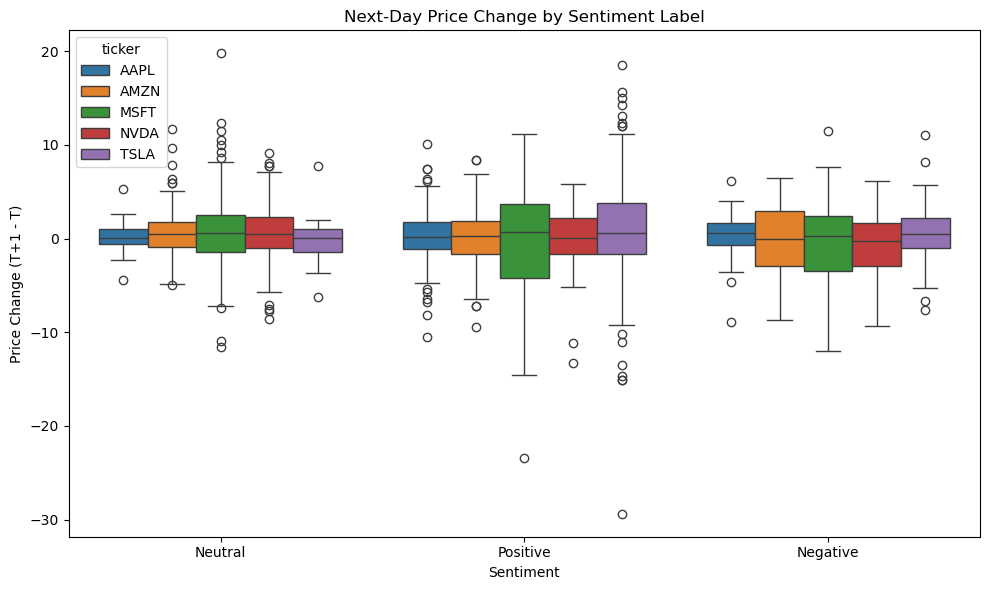

In [29]:
mer_df['next_day_return'] = mer_df['close_t_plus_1'] - mer_df['close']
mer_df['sentiment_label'] = mer_df['sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

plt.figure(figsize=(10, 6))
sns.boxplot(data=mer_df, x='sentiment_label', y='next_day_return', hue='ticker')
plt.title('Next-Day Price Change by Sentiment Label')
plt.xlabel('Sentiment')
plt.ylabel('Price Change (T+1 - T)')
plt.tight_layout()
plt.show()

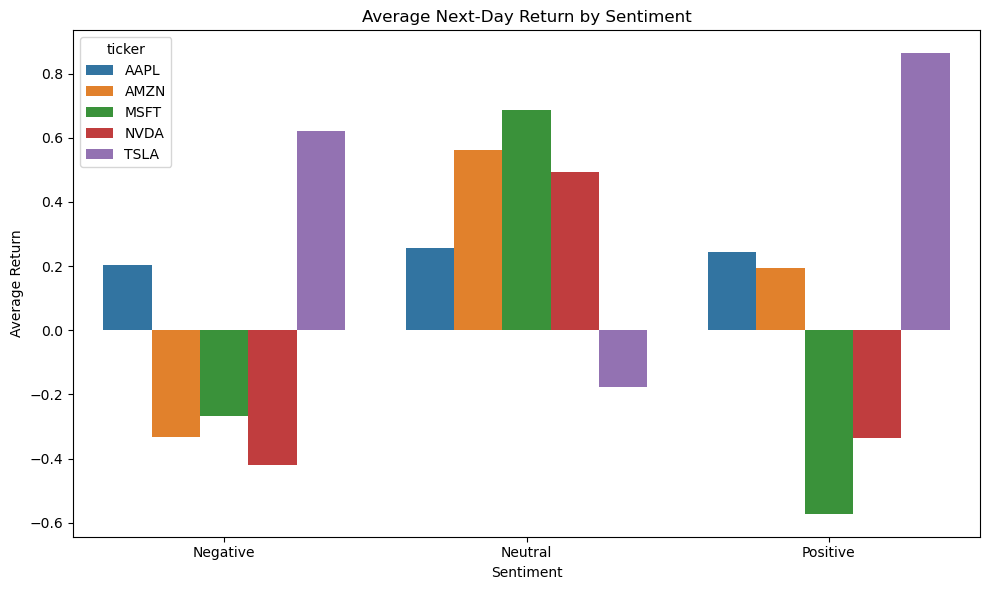

In [30]:
avg_return = mer_df.groupby(['ticker', 'sentiment_label'])['next_day_return'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_return, x='sentiment_label', y='next_day_return', hue='ticker')
plt.title('Average Next-Day Return by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Return')
plt.tight_layout()
plt.show()

In [31]:
mer_df.shape

(1235, 19)

In [32]:
mer_df = mer_df.dropna(subset=['prev_close_1', 'prev_close_2', 'prev_close_3', 'daily_return'])

In [33]:
print(f"New shape after dropping missing rows: {mer_df.shape}")

New shape after dropping missing rows: (1220, 19)


In [34]:
amzn_df = mer_df[mer_df['ticker'] == 'AMZN'].copy()
amzn_df = amzn_df[['date', 'adj_close', 'sentiment']]
amzn_df['date'] = pd.to_datetime(amzn_df['date'])
amzn_df.set_index('date', inplace=True)
amzn_df.sort_index(inplace=True)

In [35]:
result = adfuller(amzn_df['adj_close'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.1244900835437595
p-value: 0.705207398868055


In [36]:
amzn_df['adj_close_diff1'] = amzn_df['adj_close'].diff()

result_diff1 = adfuller(amzn_df['adj_close_diff1'].dropna())
print('ADF Statistic (1st diff):', result_diff1[0])
print('p-value:', result_diff1[1])


ADF Statistic (1st diff): -10.255477172778352
p-value: 4.3727997704868226e-18


In [37]:
model = SARIMAX(
    amzn_df['adj_close'],
    exog=amzn_df[['sentiment']],
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              adj_close   No. Observations:                  244
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -620.821
Date:                Wed, 21 May 2025   AIC                           1249.641
Time:                        21:00:19   BIC                           1263.580
Sample:                             0   HQIC                          1255.257
                                - 244                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sentiment      0.7629      0.585      1.305      0.192      -0.383       1.909
ar.L1         -0.6511      0.249     -2.611      0.009      -1.140      -0.162
ma.L1          1.8319      0.939      1.951      0.0

In [39]:
forecast = results.get_forecast(steps=7)

predicted_mean = forecast.predicted_mean

print("Day 1 Forecast:", predicted_mean.iloc[0])
print("Day 3 Forecast:", predicted_mean.iloc[2])
print("Day 7 Forecast:", predicted_mean.iloc[6])

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

In [ ]:
mer_df['date'] = pd.to_datetime(mer_df['date'], dayfirst=True)
mer_df = mer_df.sort_values('date')

In [ ]:
all_results = []

for ticker in mer_df['ticker'].unique():
    print(f"\nProcessing ticker: {ticker}")
    
    df = mer_df[mer_df['ticker'] == ticker].copy()
    df = df.dropna(subset=['adj_close', 'sentiment', 'close_t_plus_1', 'close_t_plus_3', 'close_t_plus_7'])
    df.set_index('date', inplace=True)
    
    y = df['adj_close']
    
    try:
        model = ARIMA(y, order=(5, 1, 0))  # ARIMA(5,1,0) as baseline
        model_fit = model.fit()
    except:
        print(f"Skipping {ticker} due to fitting error.")
        continue

In [ ]:
mer_df['date'] = pd.to_datetime(mer_df['date'], dayfirst=True)
mer_df = mer_df.sort_values('date')

all_results = []

for ticker in mer_df['ticker'].unique():
    print(f"\nProcessing ticker: {ticker}")
    
    df = mer_df[mer_df['ticker'] == ticker].copy()
    df = df.dropna(subset=['adj_close', 'sentiment', 'close_t_plus_1', 'close_t_plus_3', 'close_t_plus_7'])
    df.set_index('date', inplace=True)
    
    y = df['adj_close']
    
    try:
        model = ARIMA(y, order=(5, 1, 0)) 
        model_fit = model.fit()
    except:
        print(f"Skipping {ticker} due to fitting error.")
        continue

    forecast_steps = 7
    forecast = model_fit.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    forecasted = {
        'Day 1 Forecast': forecast_mean.iloc[0],
        'Day 3 Forecast': forecast_mean.iloc[2],
        'Day 7 Forecast': forecast_mean.iloc[6],
        'Actual Day 1': df['close_t_plus_1'].iloc[-1],
        'Actual Day 3': df['close_t_plus_3'].iloc[-1],
        'Actual Day 7': df['close_t_plus_7'].iloc[-1],
    }

    mae = mean_absolute_error(
        [forecasted['Actual Day 1'], forecasted['Actual Day 3'], forecasted['Actual Day 7']],
        [forecasted['Day 1 Forecast'], forecasted['Day 3 Forecast'], forecasted['Day 7 Forecast']]
    )
    rmse = np.sqrt(mean_squared_error(
        [forecasted['Actual Day 1'], forecasted['Actual Day 3'], forecasted['Actual Day 7']],
        [forecasted['Day 1 Forecast'], forecasted['Day 3 Forecast'], forecasted['Day 7 Forecast']]
    ))

    forecasted.update({'MAE': mae, 'RMSE': rmse, 'Ticker': ticker})
    all_results.append(forecasted)

    plt.figure(figsize=(12, 6))
    plt.plot(y, label='Historical Adj Close', color='black')
    plt.plot(forecast_index, forecast_mean, label='Forecasted Adj Close', color='blue')
    plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightblue', alpha=0.4)

    
    highlight_days = [0, 2, 6]
    highlight_dates = forecast_index[highlight_days]
    highlight_values = forecast_mean.iloc[highlight_days]
    plt.scatter(highlight_dates, highlight_values, color='red', label='Day 1, 3, 7 Forecasts')

    for i, (x, y_val) in enumerate(zip(highlight_dates, highlight_values)):
        plt.annotate(f"{y_val:.2f}", (x, y_val), textcoords="offset points", xytext=(0, 8), ha='center')

    plt.title(f'ARIMA Forecast for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(all_results)
print("\nModel Performance Summary:")
print(results_df[['Ticker', 'Day 1 Forecast', 'Actual Day 1', 'Day 3 Forecast', 'Actual Day 3',
                  'Day 7 Forecast', 'Actual Day 7', 'MAE', 'RMSE']])


In [ ]:
mer_df['date'] = pd.to_datetime(mer_df['date'], dayfirst=True)
mer_df = mer_df.sort_values(['ticker', 'date'])

all_results = []

for ticker in mer_df['ticker'].unique():
    print(f"\nProcessing ticker: {ticker}")
    
    df = mer_df[mer_df['ticker'] == ticker].copy()
    
    
    df = df.dropna(subset=['adj_close', 'sentiment', 'close_t_plus_1', 'close_t_plus_3', 'close_t_plus_7'])
    df.set_index('date', inplace=True)

    
    y = df['adj_close']
    exog = df[['sentiment']]

    try:
        model = ARIMA(y, exog=exog, order=(5, 1, 0))
        model_fit = model.fit()
    except Exception as e:
        print(f"Skipping {ticker} due to model fitting error: {e}")
        continue

    last_sentiment = exog.iloc[-1].values[0]
    future_exog = pd.DataFrame({'sentiment': [last_sentiment] * 7})

    forecast = model_fit.get_forecast(steps=7, exog=future_exog)
    forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=7, freq='B')
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    forecasted = {
        'Day 1 Forecast': forecast_mean.iloc[0],
        'Day 3 Forecast': forecast_mean.iloc[2],
        'Day 7 Forecast': forecast_mean.iloc[6],
        'Actual Day 1': df['close_t_plus_1'].iloc[-1],
        'Actual Day 3': df['close_t_plus_3'].iloc[-1],
        'Actual Day 7': df['close_t_plus_7'].iloc[-1],
    }

    mae = mean_absolute_error(
        [forecasted['Actual Day 1'], forecasted['Actual Day 3'], forecasted['Actual Day 7']],
        [forecasted['Day 1 Forecast'], forecasted['Day 3 Forecast'], forecasted['Day 7 Forecast']]
    )
    rmse = np.sqrt(mean_squared_error(
        [forecasted['Actual Day 1'], forecasted['Actual Day 3'], forecasted['Actual Day 7']],
        [forecasted['Day 1 Forecast'], forecasted['Day 3 Forecast'], forecasted['Day 7 Forecast']]
    ))

    forecasted.update({'MAE': mae, 'RMSE': rmse, 'Ticker': ticker})
    all_results.append(forecasted)

    plt.figure(figsize=(12, 6))
    plt.plot(y, label='Historical Adj Close', color='black')
    plt.plot(forecast_index, forecast_mean, label='Forecasted Adj Close', color='blue')
    plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightblue', alpha=0.4)

    highlight_days = [0, 2, 6]
    highlight_dates = forecast_index[highlight_days]
    highlight_values = forecast_mean.iloc[highlight_days]
    plt.scatter(highlight_dates, highlight_values, color='red', label='Day 1, 3, 7 Forecasts')

    for i, (x, y_val) in enumerate(zip(highlight_dates, highlight_values)):
        plt.annotate(f"{y_val:.2f}", (x, y_val), textcoords="offset points", xytext=(0, 8), ha='center')

    plt.title(f'ARIMAX Forecast for {ticker} (Sentiment as Exogenous)')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(all_results)
print("\nModel Performance Summary:")
print(results_df[['Ticker', 'Day 1 Forecast', 'Actual Day 1', 'Day 3 Forecast', 'Actual Day 3',
                  'Day 7 Forecast', 'Actual Day 7', 'MAE', 'RMSE']])


In [ ]:
window_size = 10
forecast_days = [1, 3, 7]
results_lstm = []

for ticker in mer_df['ticker'].unique():
    print(f"\nProcessing ticker: {ticker}")
    
    df = mer_df[mer_df['ticker'] == ticker].copy()
    df = df.dropna(subset=['adj_close', 'sentiment', 'close_t_plus_1', 'close_t_plus_3', 'close_t_plus_7'])
    df.sort_values('date', inplace=True)
    
    features = df[['adj_close', 'sentiment']].values
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    X, y = [], []
    for i in range(window_size, len(df) - max(forecast_days)):
        X.append(scaled_features[i - window_size:i])
        y.append([
            df['close_t_plus_1'].iloc[i],
            df['close_t_plus_3'].iloc[i],
            df['close_t_plus_7'].iloc[i]
        ])

    X, y = np.array(X), np.array(y)

    X_train, y_train = X[:-1], y[:-1]
    X_last = X[-1:]  

    
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(3))  # 3 outputs: Day 1, 3, 7
    model.compile(optimizer='adam', loss='mse')

    # Fit model
    model.fit(X_train, y_train, epochs=30, verbose=0)

    y_pred = model.predict(X_last)[0]
    actuals = [
        df['close_t_plus_1'].iloc[-1],
        df['close_t_plus_3'].iloc[-1],
        df['close_t_plus_7'].iloc[-1]
    ]

    mae = mean_absolute_error(actuals, y_pred)
    rmse = np.sqrt(mean_squared_error(actuals, y_pred))

    results_lstm.append({
        'Ticker': ticker,
        'Day 1 Forecast': y_pred[0],
        'Day 3 Forecast': y_pred[1],
        'Day 7 Forecast': y_pred[2],
        'Actual Day 1': actuals[0],
        'Actual Day 3': actuals[1],
        'Actual Day 7': actuals[2],
        'MAE': mae,
        'RMSE': rmse
    })

    plt.figure(figsize=(8, 5))
    plt.title(f'LSTM Forecast for {ticker}')
    plt.plot(['Day 1', 'Day 3', 'Day 7'], actuals, label='Actual', marker='o')
    plt.plot(['Day 1', 'Day 3', 'Day 7'], y_pred, label='Forecast', marker='x')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(results_lstm)
print("\nLSTM Model Performance Summary:")
print(results_df[['Ticker', 'Day 1 Forecast', 'Actual Day 1', 'Day 3 Forecast', 'Actual Day 3',
                  'Day 7 Forecast', 'Actual Day 7', 'MAE', 'RMSE']])

In [ ]:
plt.figure(figsize=(10, 6))
for i, row in results_df.iterrows():
    plt.plot(['D1', 'D3', 'D7'], [row['Actual Day 1'], row['Actual Day 3'], row['Actual Day 7']], 
             label=f"{row['Ticker']} - Actual", linestyle='--')
    plt.plot(['D1', 'D3', 'D7'], [row['Day 1 Forecast'], row['Day 3 Forecast'], row['Day 7 Forecast']], 
             label=f"{row['Ticker']} - Forecast", marker='o')
plt.title('Forecast vs Actual (All Tickers)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
dates = pd.date_range(start="2023-01-01", periods=100)
tickers = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'TSLA']
np.random.seed(42)
df = pd.concat([
    pd.DataFrame({
        'Date': dates,
        'Ticker': ticker,
        'Adj Close': np.cumsum(np.random.randn(100)) + 100 + i*20,
        'Sentiment': np.random.normal(0, 0.5, 100)
    }) for i, ticker in enumerate(tickers)
])

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

results = []

for ticker in tickers:
    print(f"Processing {ticker}...")
    df_ticker = df[df['Ticker'] == ticker][['Adj Close', 'Sentiment']].copy()

    arima_model = ARIMA(df_ticker['Adj Close'], order=(5,1,0))
    arima_result = arima_model.fit()
    arima_forecast = arima_result.forecast(steps=7)

    df_ticker['ARIMA_Fitted'] = arima_result.fittedvalues
    df_ticker['Residuals'] = df_ticker['Adj Close'] - df_ticker['ARIMA_Fitted']

    residuals = df_ticker['Residuals'].dropna().values.reshape(-1, 1)
    scaler = MinMaxScaler()
    residuals_scaled = scaler.fit_transform(residuals)

    X, y = [], []
    for i in range(10, len(residuals_scaled) - 7):
        X.append(residuals_scaled[i-10:i])
        y.append(residuals_scaled[i:i+7].flatten())
    X, y = np.array(X), np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(7))  # Predict next 7 residuals
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    last_window = residuals_scaled[-10:].reshape((1, 10, 1))
    residual_preds_scaled = model.predict(last_window)[0]
    residual_preds = scaler.inverse_transform(residual_preds_scaled.reshape(-1, 1)).flatten()

    hybrid_forecast = arima_forecast.values + residual_preds

    actuals = df_ticker['Adj Close'].iloc[-7:].values
    forecast_days = [1, 3, 7]

    mae = mean_absolute_error(actuals, hybrid_forecast[:7])
    rmse = math.sqrt(mean_squared_error(actuals, hybrid_forecast[:7]))

    results.append({
        'Ticker': ticker,
        'Day 1 Forecast': hybrid_forecast[0],
        'Actual Day 1': actuals[0],
        'Day 3 Forecast': hybrid_forecast[2],
        'Actual Day 3': actuals[2],
        'Day 7 Forecast': hybrid_forecast[6],
        'Actual Day 7': actuals[6],
        'MAE': mae,
        'RMSE': rmse
    })

    plt.figure(figsize=(10, 5))
    plt.plot(df_ticker.index[-30:], df_ticker['Adj Close'][-30:], label='Actual Price')
    plt.plot(pd.date_range(df_ticker.index[-1], periods=8, freq='D')[1:], hybrid_forecast, label='Hybrid Forecast', linestyle='--')
    plt.title(f"{ticker} Hybrid ARIMA+LSTM Forecast")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

performance_df = pd.DataFrame(results)
performance_df = performance_df[['Ticker', 'Day 1 Forecast', 'Actual Day 1',
                                 'Day 3 Forecast', 'Actual Day 3',
                                 'Day 7 Forecast', 'Actual Day 7',
                                 'MAE', 'RMSE']]
performance_df


In [ ]:
lookback = 30
forecast_horizons = [1, 3, 7]

def prepare_data_multistep(ticker_df, lookback=30):
    ticker_df = ticker_df.rename(columns=str.lower)
    features = ['adj_close', 'sentiment']
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(ticker_df[features])

    X, y = [], []
    for i in range(lookback, len(scaled_data) - max(forecast_horizons)):
        X.append(scaled_data[i - lookback:i])
        y.append([scaled_data[i + h][0] for h in forecast_horizons])  # only adj_close targets
    return np.array(X), np.array(y), scaler

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        return_sequences=False,
        input_shape=(lookback, 2)
    ))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(3)) 
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='mse'
    )
    return model

tickers = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'TSLA']
results = {}

for ticker in tickers:
    print(f"\n🔧 Tuning model for {ticker}...")
    df_ticker = mer_df[mer_df['ticker'] == ticker].sort_values('date').reset_index(drop=True)
    X, y, scaler = prepare_data_multistep(df_ticker, lookback=lookback)

    split = int(len(X) * 0.8)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    tuner = RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='tuner_logs',
        project_name=f'{ticker}_lstm_multi'
    )

    tuner.search(X_train, y_train, epochs=10, validation_split=0.2,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.summary()

    predictions = best_model.predict(X_test)

    inv_predictions = []
    inv_actuals = []
    for i in range(3):
        pred_i = np.column_stack((predictions[:, i], np.zeros(len(predictions))))
        actual_i = np.column_stack((y_test[:, i], np.zeros(len(y_test))))

        inv_pred = scaler.inverse_transform(pred_i)[:, 0]
        inv_actual = scaler.inverse_transform(actual_i)[:, 0]

        inv_predictions.append(inv_pred)
        inv_actuals.append(inv_actual)

    inv_predictions = np.stack(inv_predictions, axis=1)
    inv_actuals = np.stack(inv_actuals, axis=1)

    mae = np.mean(np.abs(inv_predictions - inv_actuals), axis=0)
    rmse = np.sqrt(np.mean((inv_predictions - inv_actuals)**2, axis=0))

    results[ticker] = {
        'Day 1 MAE': mae[0], 'Day 3 MAE': mae[1], 'Day 7 MAE': mae[2],
        'Day 1 RMSE': rmse[0], 'Day 3 RMSE': rmse[1], 'Day 7 RMSE': rmse[2]
    }

result_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Ticker'})

print("\n📊 Forecasting Results:")
print(result_df.round(3))

In [53]:
from graphviz import Digraph

dot = Digraph(comment='Assignment Data Pipeline')

dot.node('A', 'Explore the Data')
dot.node('B', 'Store Stock Data\non Cassandra')
dot.node('C', 'Store StockTweets\non MongoDB')
dot.node('D', 'Spark Process & Merge Data')
dot.node('E', 'Store Merged Data\ninto Cassandra')
dot.node('F', 'Export Merged Data\nto CSV')
dot.node('G', 'Use YCSB for\nBenchmarking')
dot.node('H', 'Use Kafka for\nData Streamline')

# Arrows to show flow
dot.edge('A', 'B')
dot.edge('A', 'C')
dot.edge('B', 'D')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('E', 'G')
dot.edge('E', 'H')

dot.render('data_pipeline.gv', view=True)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [51]:
!pip install graphviz
